In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import tensorflow.keras.backend as K

In [ ]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 2: # 6:3:1
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 3: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)
 
  return train_data, test_data, val_data

In [ ]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv')#, parse_dates=['Date'], index_col='Date')

n_steps = 3
n_features = 1

train_data, test_data, val_data = split_data(df, 2)

Train:  801
Test:  400
Val:  134


In [ ]:
def create_dataset(df, lookback=3):
    data = np.array(df['Price'])
    
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

lookback = 3
X_train, y_train = create_dataset(train_data, lookback)
X_val, y_val = create_dataset(val_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

In [ ]:
# Bayesian Neural Network

input_shape = (lookback,)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(tfp.layers.DenseFlipout(32, activation='relu'))
model.add(tfp.layers.DenseFlipout(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flipout_2 (DenseFlipo  (None, 32)               224       
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 1)                65        
 ut)                                                             
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:

model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 2s 19ms/step - loss: 8024.6924 - val_loss: 57611.0547
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 4936.2437 - val_loss: 31196.0117
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 2387.0005 - val_loss: 12297.2158
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 997.7639 - val_loss: 2419.9026
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 469.6620 - val_loss: 1175.6676
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 417.5677 - val_loss: 1284.3556
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 451.2368 - val_loss: 1239.0190
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 434.5459 - val_loss: 1600.5314
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 414.5574 - val_loss: 1603.1218
Epoch 10/100
25/25 [==============================] - 0s 

In [ ]:
# evaluate trên tập test
loss = model.evaluate(X_test, y_test, verbose=0)
print("Loss: ", loss)

Loss:  838.68359375


In [ ]:
# evaluate trên tập val
loss = model.evaluate(X_val, y_val, verbose=0)
print("Loss: ", loss)

Loss:  527.1127319335938


In [ ]:
def rmse_mape(true, predict):
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return rmse, mape

In [ ]:
rmse_mape(y_val, model.predict(X_val))

5/5 [==============================] - 0s 4ms/step


(15.350736610973955, 0.0663736984128761)

In [ ]:
rmse_mape(y_test, model.predict(X_test))

13/13 [==============================] - 0s 3ms/step


(25.556346977485987, 0.07585555189722223)

In [ ]:
NUM_SAMPLES = len(X_val)

# dự đoán for X_val
y_pred = np.zeros((NUM_SAMPLES, len(X_val)))
for i in range(NUM_SAMPLES):
    y_pred[i] = model.predict(X_val).flatten()

# Tính mean and standard deviation của predictions
y_mean = np.mean(y_pred, axis=0)
y_std = np.std(y_pred, axis=0)

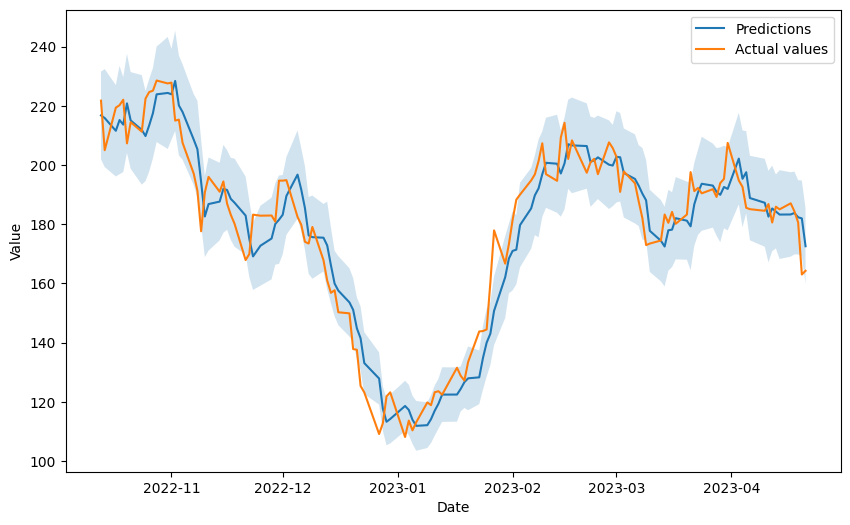

In [ ]:
# Chuyển date strings sang datetime objects
dates = pd.to_datetime(val_data['Date'][lookback:])

# Biểu diễn
plt.figure(figsize=(10, 6))
plt.plot(dates, y_mean, label='Predictions')
plt.fill_between(dates, y_mean - y_std, y_mean + y_std, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được
plt.plot(dates, y_val, label='Actual values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
y_pred_test = np.zeros((len(X_test), len(X_test)))
for i in range(len(X_test)):
    y_pred_test[i] = model.predict(X_test).flatten()

y_pred_val = np.zeros((len(X_val), len(X_val)))
for i in range(len(X_val)):
    y_pred_val[i] = model.predict(X_val).flatten()

In [ ]:
# Compute mean and standard deviation of predictions
y_mean_test = np.mean(y_pred_test, axis=0)
y_std_test = np.std(y_pred_test, axis=0)

y_mean_val = np.mean(y_pred_val, axis=0)
y_std_val = np.std(y_pred_val, axis=0)

In [ ]:
dates_train = pd.to_datetime(train_data['Date'][lookback:])
dates_val = pd.to_datetime(val_data['Date'][lookback:])
dates_test = pd.to_datetime(test_data['Date'][lookback:])

In [ ]:
future_dates = pd.date_range(start=dates_val.iloc[-1], periods=30, closed='right')
future_inputs = X_val[:30]
#future_inputs = np.zeros((30, lookback))

# Generate predictions for the next 30 days
future_predictions = np.zeros((NUM_SAMPLES, 30))
for i in range(NUM_SAMPLES):
    future_predictions[i] = model.predict(future_inputs).flatten()

# Compute mean and standard deviation of future predictions
future_mean = np.mean(future_predictions, axis=0)
future_std = np.std(future_predictions, axis=0)

# Plot predictions for the next 30 days
future_dates_all = pd.date_range(start=dates_val.iloc[-1], periods=31, closed='right')

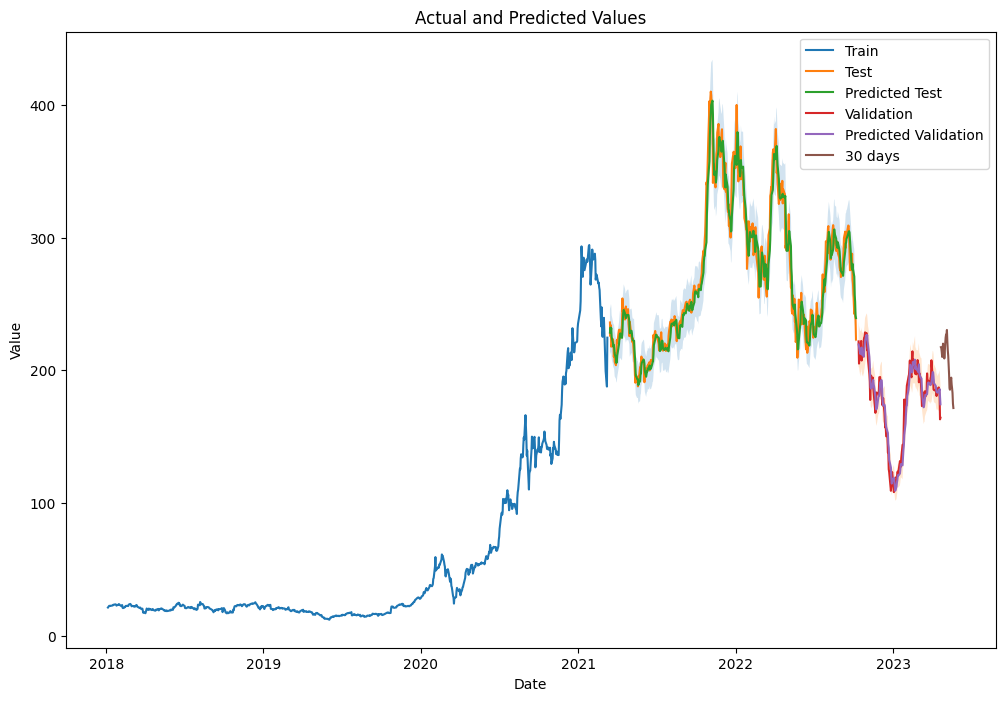

In [ ]:


plt.figure(figsize=(12, 8))
plt.plot(dates_train, y_train, label='Train')
plt.plot(dates_test, y_test, label='Test')
plt.plot(dates_test, y_mean_test.reshape(-1, 1), label='Predicted Test')
plt.fill_between(dates_test, y_mean_test - y_std_test, y_mean_test + y_std_test, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

plt.plot(dates_val, y_val, label='Validation')
plt.plot(dates_val, y_mean_val.reshape(-1, 1), label='Predicted Validation')
plt.fill_between(dates_val, y_mean_val - y_std_val, y_mean_val + y_std_val, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

plt.plot(future_dates_all, future_mean.reshape(-1, 1), label='30 days')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Actual and Predicted Values')
plt.show()

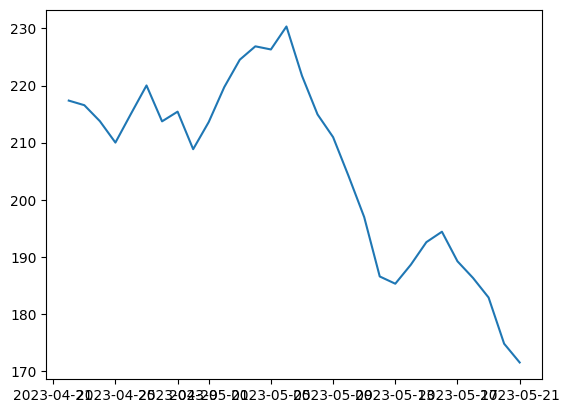

In [ ]:
plt.plot(future_dates_all, future_mean.reshape(-1, 1), label='Validation')